In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pubmed-200k-rtc:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2752513%2F5129127%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240412%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240412T090007Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc2a8c8a59365c36d9de8de1e769527c5cb2fd2a9132c47eb4b469c6a8c63b41bb46394a82c36d156b08a4f0cc70d7cb673c1a75f9858f7ac3ad8332c3853e7cdd7a24ad1cc7e38393ae985f16ef3da35ab9fbf3d86bd9cb14fc6996df6abb77f48196195ae05ec690f88592b3df5f0a76887c83d5042e383d4382de04eb00b0254e056c8185a6d1c054ccc5178db2cc0a32c77858ff2f4515da829ae816592586e0b6d2739c899c727442b3f55fc40c95137708c8ec405a7fac8a916276a588abf3be34175447bff4804e5f64d07018aba10f3df9ff4cceb097031ac539297db9ba2c9fec465297bb5d9f6a020a568cbdf3653e102b1e444002d90aef8d7faf5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 541039768 bytes downloaded
Downloaded and uncompressed: pubmed-200k-rtc
Data source import complete.


In [ ]:
!pip install torchinfo

In [ ]:
! pip -q install torchview

In [ ]:
import re
import random
import os
import glob
import time
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchtext
import torch.optim.lr_scheduler as lr_scheduler

from torchinfo import summary
from torch import nn
from torch.utils.data import (Dataset, DataLoader)

from tqdm.notebook import tqdm
from transformers import (AutoTokenizer, DebertaV2Model)
from typing import Dict, List, Tuple


from sklearn.preprocessing import (OneHotEncoder, LabelEncoder)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score,
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

In [ ]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
plt.style.use('dark_background')

In [ ]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    MODEL_NAME = 'google/electra-base-discriminator'

    LR = 0.001
    APPLY_SHUFFLE = False
    SEED = 768
    TARGET ='target'
    MAX_LENGTH = 68
    NUM_CLASSES = 5
    EPOCHS = 4
    PATIENS = 1
    THRESHOLD = 0.01
    BATCH_SIZE = (
        256 if torch.cuda.device_count() < 2
        else (256 * torch.cuda.device_count())
    )

    # Define paths
    DATASET_PATH = "/kaggle/input/pubmed-200k-rtc/"
    TRAIN_CSV = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/train.csv'
    VAL_CSV = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/dev.csv'
    TEST_CSV = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/test.csv'


#LOADING DATA

In [ ]:
def reduce_memory(df:pd.DataFrame, verbose:bool=True) -> pd.DataFrame:
    original_memory = (df.memory_usage().sum()) / (1024 ** 2)

    for column in df.columns:
        column_dtype = df[column].dtype

        if (column_dtype != object) and (column_dtype != str):
            if (str(column_dtype) + '______')[:3] == 'int':
                df[column] = df[column].astype(np.int32)
            if (str(column_dtype) + '______')[:5] == 'float':
                df[column] = df[column].astype(np.float32)

    if verbose:
        print('-----------------------------------------------------')
        print(f'Memory usage of dataframe:\t\t{original_memory:.2f} MB')

        altered_memory = df.memory_usage().sum() / 1024**2
        print(f'Memory usage after dtype conversion:\t{altered_memory:.2f} MB')

        memory_variance = 100 * (original_memory - altered_memory) / original_memory
        print(f'Memory consumption decreased by:\t{memory_variance:.2f}%')
        print('-----------------------------------------------------')

    return df

In [ ]:
# Load train set from csv
print('Loading Training Data...')
train_df = reduce_memory(pd.read_csv(CFG.TRAIN_CSV))

# Load val/dev set from csv
print('\nLoading Val/Dev Data...')
val_df = reduce_memory(pd.read_csv(CFG.VAL_CSV))

# Load test set from csv
print('\nLoading Test Data...')
test_df = reduce_memory(pd.read_csv(CFG.TEST_CSV))

print('\nLoading Complete!')

Loading Training Data...
-----------------------------------------------------
Memory usage of dataframe:		8.24 MB
Memory usage after dtype conversion:	6.18 MB
Memory consumption decreased by:	25.00%
-----------------------------------------------------

Loading Val/Dev Data...
-----------------------------------------------------
Memory usage of dataframe:		1.38 MB
Memory usage after dtype conversion:	1.04 MB
Memory consumption decreased by:	25.00%
-----------------------------------------------------

Loading Test Data...
-----------------------------------------------------
Memory usage of dataframe:		1.38 MB
Memory usage after dtype conversion:	1.03 MB
Memory consumption decreased by:	25.00%
-----------------------------------------------------

Loading Complete!


In [ ]:
# View train samples
train_df.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,METHODS


In [ ]:
# Group all datasets into dictionary
ds = {
    'train_df': train_df,
    'val_df'  : val_df,
    'test_df' : test_df
}

# View dataset info
for _ in list(ds.keys()):
    print('====================================')
    print(f'Viewing {_} info:\n')
    print(ds[_].info(show_counts=True), '\n')

Viewing train_df info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180040 entries, 0 to 180039
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   abstract_id    180040 non-null  int32 
 1   line_id        180040 non-null  object
 2   abstract_text  180040 non-null  object
 3   line_number    180040 non-null  int32 
 4   total_lines    180040 non-null  int32 
 5   target         180040 non-null  object
dtypes: int32(3), object(3)
memory usage: 6.2+ MB
None 

Viewing val_df info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30212 entries, 0 to 30211
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   abstract_id    30212 non-null  int32 
 1   line_id        30212 non-null  object
 2   abstract_text  30212 non-null  object
 3   line_number    30212 non-null  int32 
 4   total_lines    30212 non-null  int32 
 5   target         30212 

In [ ]:
# Calculate total samples
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		180040	(74.90%)
validation samples count:	30212	(12.57%)
test samples count:		30135	(12.54%)
TOTAL:				240387	(100.00%)


#Transfer Learning

In [ ]:
# Get DeBERTa Tokenizer
tokenizer = (
    AutoTokenizer
    .from_pretrained(CFG.MODEL_NAME)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from transformers import ElectraModel

# Get ELECTRA model
backbone_model = ElectraModel.from_pretrained(CFG.MODEL_NAME)

# Freeze Model Parameters
for param in backbone_model.parameters():
    param.requires_grad = False

# Push model onto GPU
backbone_model = backbone_model.to(CFG.DEVICE)


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:

class ElectraV3Model(nn.Module):
    def __init__(self, backbone_model, name='electra-v3-base',
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(ElectraV3Model, self).__init__()
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name

        self.current_line_stream = nn.Sequential(
            nn.Linear(in_features=1, out_features=16, bias=True),
            nn.GELU(),
        ).to(device)

        self.total_lines_stream = nn.Sequential(
            nn.Linear(in_features=1, out_features=16, bias=True),
            nn.GELU(),
        ).to(device)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=800, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=self.num_classes, bias=False)
        ).to(device)

    def mean_pooling(self, inputs, outputs):
        input_mask_expanded = (
            inputs['attention_mask']
            .squeeze()
            .unsqueeze(-1)
            .expand(outputs.last_hidden_state.size())
            .float()
        )
        sum_embeddings = torch.sum(
            outputs.last_hidden_state * input_mask_expanded, 1
        )
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask

        return mean_embeddings

    def forward(self, tokens, line_number, total_lines):
        backbone_output = self.backbone_model(**tokens)
        pooled_output = self.mean_pooling(tokens, backbone_output)

        line_number_out = self.current_line_stream(
            line_number.view(line_number.size(0), -1).to(dtype=torch.float32)
        )
        total_lines_out = self.total_lines_stream(
            total_lines.view(total_lines.size(0), -1).to(dtype=torch.float32)
        )

        concat_layer = torch.cat((pooled_output, line_number_out, total_lines_out), dim=1)

        model_output = self.classifier(concat_layer)

        return model_output


In [ ]:
# Define ELECTRA model parameters
electra_params = {
    'backbone_model': backbone_model,
    'name'          : 'electra-v3-base',
    'device'         : CFG.DEVICE
}

# Generate ELECTRA model
electra_model = ElectraV3Model(**electra_params)


# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    deberta_model = nn.DataParallel(electra_model)

In [ ]:
electra_model

ElectraV3Model(
  (backbone_model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

#Building Data Pipeline for training and testing

In [ ]:
def text_processor(text):

    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    # -----------------------------------------------------
    non_ascii_pattern = re.compile(r"[^\x00-\x7F]+", flags=re.UNICODE)
    digit_pattern = re.compile('[0-9]', flags=re.UNICODE)

    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/21932615/regular-expression-for-remove-link
    link_pattern = re.compile('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', flags=re.UNICODE)
    # -----------------------------------------------------

    # Remove emojis
    preprocessed_text = emoji_pattern.sub(r'', text)
    # Remoce non-ascii characters
    preprocessed_text = non_ascii_pattern.sub(r'', preprocessed_text)
    # Replace numbers with '@' sign
    preprocessed_text = digit_pattern.sub(r'#', preprocessed_text)
    # Remove web links
    preprocessed_text = link_pattern.sub(r'', preprocessed_text)

    return preprocessed_text

In [ ]:
class PubMedDataset(Dataset):
    def __init__(self, df:pd.DataFrame, tokenizer,
                 max_length=64, text_filter=None) -> None:
        super().__init__()

        self.texts = df['abstract_text'].to_list()
        self.line_numbers = df['line_number'].to_list()
        self.total_abstract_lines = df['total_lines'].to_list()
        self.labels = df['target'].to_list()

        self.tokenizer = tokenizer
        self.max_length = max_length
        self.text_filter = text_filter

        self.classes = sorted(list(df['target'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}

    def tokenize_text(self, text):
        tokenize_params = {
            'text'                  : text,
            'add_special_tokens'    : True,
            'truncation'            : True,
            'padding'               : 'max_length',
            'max_length'            : self.max_length,
            'return_tensors'        : 'pt'
        }

        return self.tokenizer(**tokenize_params)

    def __len__(self) -> int:
        return self.texts.__len__()

    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        text = (self.texts[index])

        # Transform if necessary
        if self.text_filter:
            text = self.text_filter(text)

        text = self.tokenize_text(text)
        text = {k:text[k].squeeze() for k in text.keys()}

        line_number = float(self.line_numbers[index])
        total_lines = float(self.total_abstract_lines[index])

        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        return (text, line_number, total_lines), class_idx

<a id=4.1></a>
### Build DataLoaders from Custom Datasets

In [ ]:
def generate_pipeline(
    df, model_tokenizer, filter_fn,
    max_len=CFG.MAX_LENGTH,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE) -> Tuple[Dataset, DataLoader]:

    # Build Custom Dataset
    ds = PubMedDataset(
        df, model_tokenizer,
        max_length=max_len,
        text_filter=filter_fn
    )

    # Generate DataLoader
    loader = DataLoader(
        dataset=ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle
    )

    return ds, loader

In [ ]:
# Build train dataset & dataloader
train_ds, train_loader = generate_pipeline(
    train_df,
    tokenizer,
    text_processor,
    max_len=CFG.MAX_LENGTH,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build val dataset & dataloader
val_ds, val_loader = generate_pipeline(
    val_df,
    tokenizer,
    text_processor,
    max_len=CFG.MAX_LENGTH,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# Build test dataset & dataloader
test_ds, test_loader = generate_pipeline(
    test_df,
    tokenizer,
    text_processor,
    max_len=CFG.MAX_LENGTH,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

#Train Model

In [ ]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer
optimizer = torch.optim.Adam(
    electra_model.parameters(),
    lr=CFG.LR
)

# Define Scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=CFG.PATIENS,
    threshold=CFG.THRESHOLD,
    threshold_mode='abs',
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into training mode
    model.train()

    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0

    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Push data onto target device
        tokens, current_line, total_lines = X[0], X[1], X[2]
        tokens = {k:tokens[k].to(device) for k in tokens.keys()}
        current_line = current_line.to(device)
        total_lines = total_lines.to(device)
        y = y.to(device)

        # Feed-forward and compute metrics
        logits = model(tokens, current_line, total_lines)
        loss = loss_fn(logits, y)
        train_loss += loss.item()

        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()

        # Update Model Gradients
        optimizer.step()

        # Compute Batch Metrics
        y_pred = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(y_pred, dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)

        # Release data from memory
        del X, y
        garb = gc.collect()

    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

#Define Evaluation Step

In [ ]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:

    # Set model into eval mode
    model.eval()

    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Push data onto target device
            tokens, current_line, total_lines = X[0], X[1], X[2]
            tokens = {k:tokens[k].to(device) for k in tokens.keys()}
            current_line = current_line.to(device)
            total_lines = total_lines.to(device)
            y = y.to(device)

            # Feed-forward and compute metrics
            logits = model(tokens, current_line, total_lines)
            loss = loss_fn(logits, y)
            eval_loss += loss.item()

            # Compute Batch Metrics
            y_pred = torch.softmax(logits, dim=1)
            predicted_class = torch.argmax(y_pred, dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)

            # Release data from memory
            del X, y
            garb = gc.collect()

    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)

    return eval_loss, eval_acc

#Construct Training loop

In [ ]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    scheduler:torch.optim.lr_scheduler,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:

    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }

    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model,
            train_dataloader,
            optimizer,
            loss_fn,
            device
        )

        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model,
            eval_dataloader,
            loss_fn,
            device
        )

        # Execute schedular step
        current_lr = 0
        if scheduler:
            scheduler.step(eval_loss)
            current_lr = optimizer.param_groups[0]['lr']

        # Log Epoch Metrics
        log_text = f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}'

        if scheduler:
            print(log_text + f' - lr: {current_lr}')
        else:
            print(log_text)

        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)

    # Return Session Metrics
    return session

#Train Electra Model


In [ ]:
# Train the model
print('Training Electra Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

session_config = {
    'model'               : electra_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'scheduler'           : scheduler,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

session_history = train(**session_config)

Training Electra Model
Train on 180040 samples, validate on 30212 samples.
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1/4


  0%|          | 0/704 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
def predict(
    model:nn.Module,
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:

    # Set model into eval mode
    model.eval()

    predictions = []

    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Push data onto target device
            tokens, current_line, total_lines = X[0], X[1], X[2]
            tokens = {k:tokens[k].to(device) for k in tokens.keys()}
            current_line = current_line.to(device)
            total_lines = total_lines.to(device)
            y = y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(tokens, current_line, total_lines)

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()

            # Record prediction
            predictions.append(predicted_probs)

    return np.vstack(predictions)

In [ ]:
# Generate test sample probabilities
test_probs = predict(electra_model, test_loader, CFG.DEVICE)

In [ ]:
# Generate test sample preditions
test_preds = np.argmax(test_probs, axis=1)

In [ ]:
# Create Model directory
model_name = 'abstract_segmentation_model'
model_path = '/kaggle/working/model/'
os.mkdir(model_path)

In [ ]:
def plot_training_curves(history):

    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuaracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o', color='C5')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o', color='C6')
    ax1.set_xticks(np.arange(0, len(epochs), step=1))

    ax1.fill_between(
        epochs, loss, val_loss,
        where=(loss > val_loss),
        color='C5', alpha=0.3,
        interpolate=True
    )
    ax1.fill_between(
        epochs, loss, val_loss,
        where=(loss < val_loss),
        color='C6', alpha=0.3,
        interpolate=True
    )

    ax1.set_title('Loss (Lower Means Better)', fontsize=18)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend(fontsize=12)

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o', color='C5')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o', color='C6')
    ax2.set_xticks(np.arange(0, len(epochs), step=1))

    ax2.fill_between(
        epochs, accuracy, val_accuracy,
        where=(accuracy > val_accuracy),
        color='C5', alpha=0.3,
        interpolate=True
    )
    ax2.fill_between(
        epochs, accuracy, val_accuracy,
        where=(accuracy < val_accuracy),
        color='C6', alpha=0.3,
        interpolate=True
    )

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=18)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend(fontsize=12);

    sns.despine();

    return

In [ ]:
# Convert history dict to DataFrame
session_history_df = pd.DataFrame(session_history)
session_history_df

In [ ]:
# Plot session training history
plot_training_curves(session_history)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

In [ ]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

plot_confusion_matrix(
    test_labels,
    test_preds,
    figsize=(14, 8),
    classes=test_ds.classes)

In [ ]:
def generate_performance_scores(y_true, y_pred, y_probabilities):

    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(
        y_true, y_probabilities, k=3
    )
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'top_3_accuracy'       : top_3_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
# Generate DeBERTa model performance scores
model_performance = generate_performance_scores(
    test_labels,
    test_preds,
    test_probs
)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Accuracy'),
  Text(1, 0, 'Top 3 Accuracy'),
  Text(2, 0, 'Precision'),
  Text(3, 0, 'Recall'),
  Text(4, 0, 'F1 Score'),
  Text(5, 0, 'MCC')])

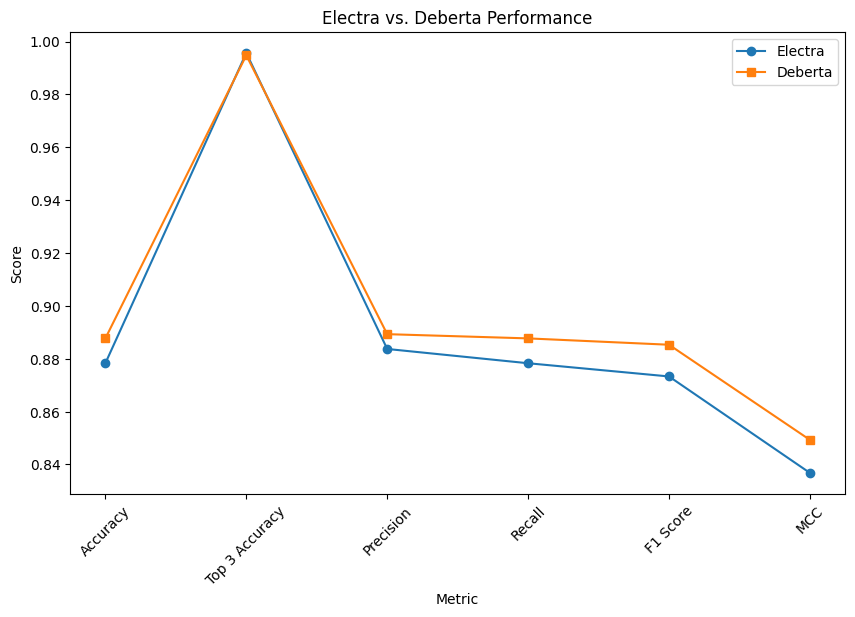

In [ ]:
import matplotlib.pyplot as plt

# Define data for Electra and Deberta
electra_metrics = {
    "Metric": ["Accuracy", "Top 3 Accuracy", "Precision", "Recall", "F1 Score", "MCC"],
    "Score": [0.8783, 0.9957, 0.8837, 0.8783, 0.8733, 0.8368]
}

deberta_metrics = {
    "Metric": ["Accuracy", "Top 3 Accuracy", "Precision", "Recall", "F1 Score", "MCC"],
    "Score": [0.8877, 0.9948, 0.8893, 0.8877, 0.8853, 0.8493]
}

# Create line plot
plt.figure(figsize=(10, 6))

# Plot Electra data
plt.plot(electra_metrics["Metric"], electra_metrics["Score"], marker='o', label='Electra')

# Plot Deberta data
plt.plot(deberta_metrics["Metric"], deberta_metrics["Score"], marker='s', label='Deberta')

# Set labels and title
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Electra vs. Deberta Performance")

# Add legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display plot (This line would be executed to show the plot)
# plt.show()
